In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [2]:
oilPrices = pd.read_csv('BrentOilPrices.csv')
oilPrices.columns=['date', 'price']
oilPrices.head()

,date,price
0,"May 20, 1987",18.63
1,"May 21, 1987",18.45
2,"May 22, 1987",18.55
3,"May 25, 1987",18.60
4,"May 26, 1987",18.63


In [4]:
oilPrices.shape

(8216, 2)

In [5]:
oilPrices.dtypes

date      object
price    float64
dtype: object

In [6]:
#Cast Date Column to type date
oilPrices['date'] = pd.to_datetime(oilPrices['date'])

In [7]:
oilPrices.set_index('date', inplace=True)
oilPrices = oilPrices.resample('D').ffill().reset_index()

In [8]:
oilPrices.isnull().values.any()

False

In [9]:
oilPrices['year']=oilPrices['date'].dt.year
oilPrices['month']=oilPrices['date'].dt.month
oilPrices['week']=oilPrices['date'].dt.week

In [10]:
train = oilPrices[(oilPrices['date' ] > '2000-01-01') & (oilPrices['date' ] <= '2018-12-31')]
test = oilPrices[oilPrices['date' ] >= '2019-01-01']

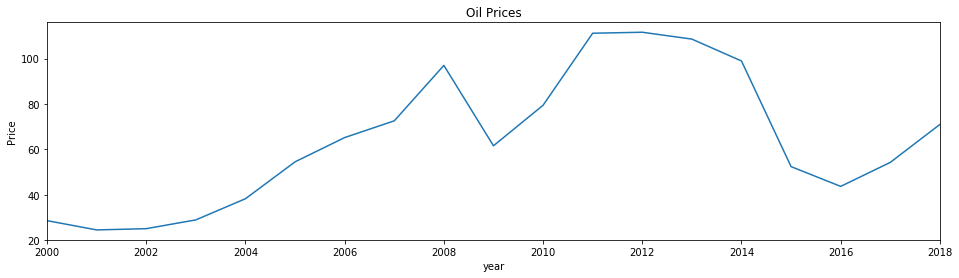

In [11]:
yearlyPrice=train.groupby(["year"])['price'].mean()
plt.figure(figsize=(16,4))
plt.title('Oil Prices')
plt.xlabel('Year')
plt.ylabel('Price')
yearlyPrice.plot()
plt.show();

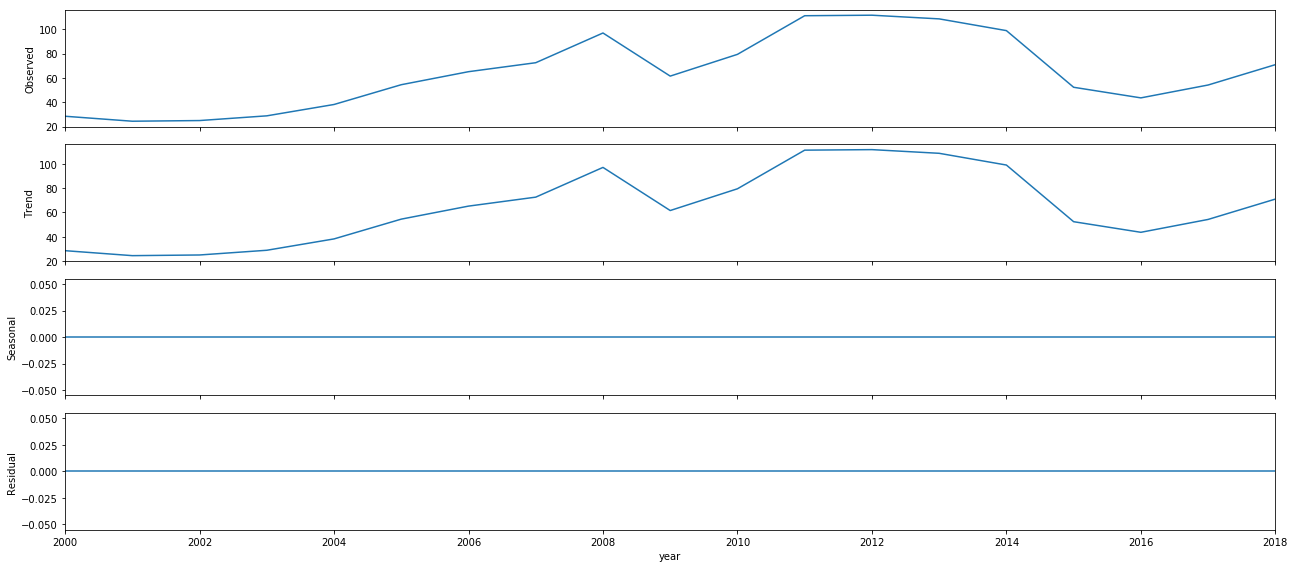

In [12]:
#time-series to decompose our time series into three distinct components: trend, seasonality, and noise.
monthlyPrice=oilPrices.groupby(["month"])['price'].mean()
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(yearlyPrice, freq=1, model='additive')
fig = decomposition.plot()
plt.show()

In [14]:
series=pd.Series(data=train['price'].to_numpy(), index=train['date'])
#check if the Index is Datetime format
series.index

DatetimeIndex(['2000-01-02', '2000-01-03', '2000-01-04', '2000-01-05',
               '2000-01-06', '2000-01-07', '2000-01-08', '2000-01-09',
               '2000-01-10', '2000-01-11',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=6939, freq=None)

In [15]:
#The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.000744
p-value: 0.286247


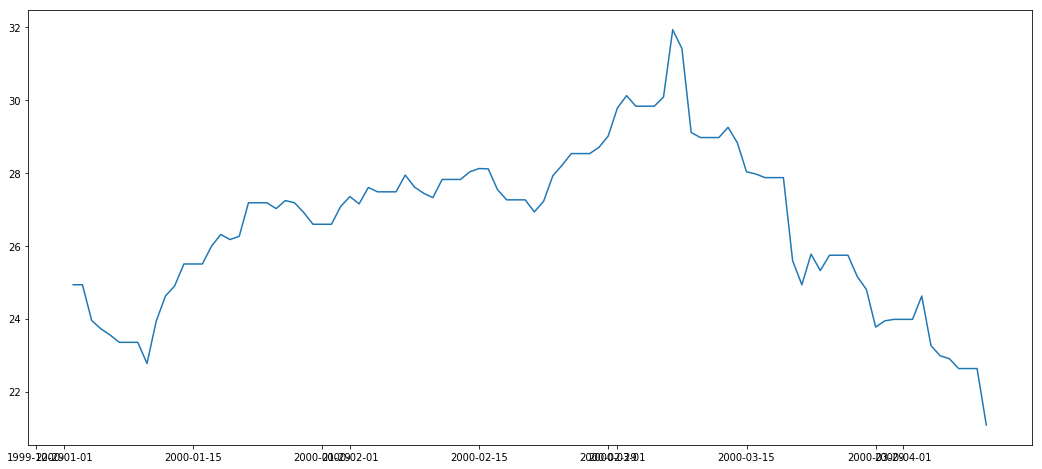

In [16]:
#Look if there is a stationary data, which looks non stationary
#We need stationary data to make time series forecasting
plt.plot(series[0:100])
plt.show()

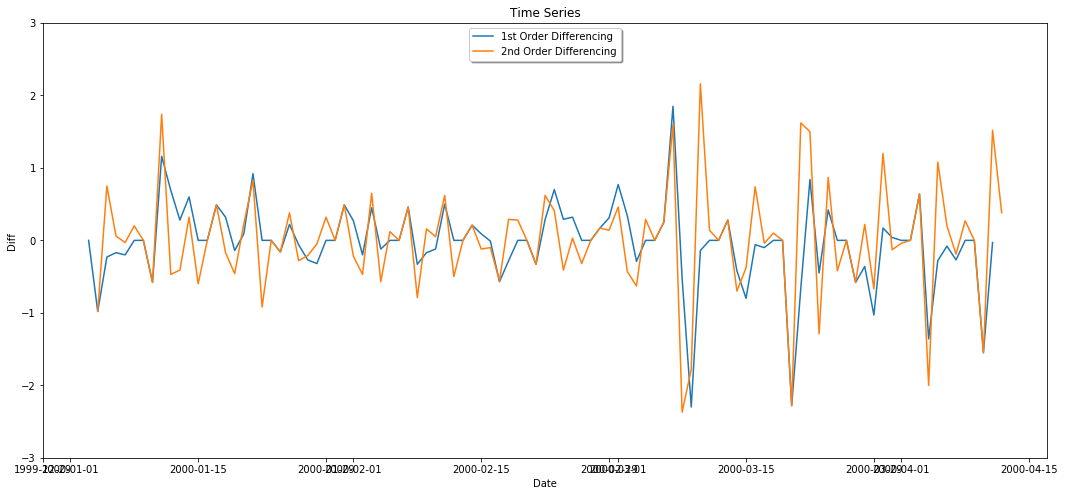

In [17]:
#find the order of differencing (d) in ARIMA model; hence the purpose of differencing it to make the time series stationary
daily_series_diff1 = series.diff(periods=1).dropna()
daily_series_diff2 = daily_series_diff1.diff(periods=1).dropna()
fig, ax = plt.subplots()
ax.plot(daily_series_diff1[0:100], label='1st Order Differencing')
ax.plot(daily_series_diff2[0:100], label='2nd Order Differencing')
plt.ylim([-3,3])
legend = ax.legend(loc='upper center', shadow=True)
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('Diff')
plt.show()

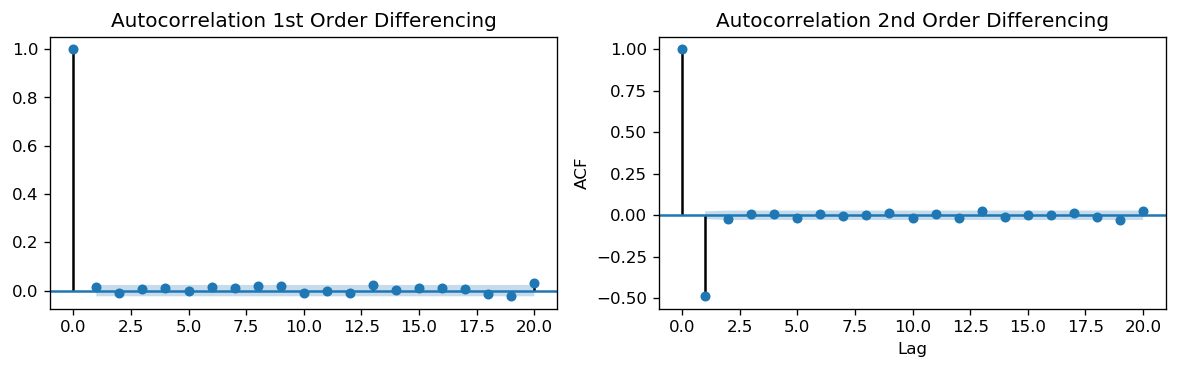

In [18]:
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(1, 2, sharex=True)
plot_acf(daily_series_diff1, lags=20, ax=axes[0], title="Autocorrelation 1st Order Differencing")
plot_acf(daily_series_diff2, lags=20, ax=axes[1], title="Autocorrelation 2nd Order Differencing")
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

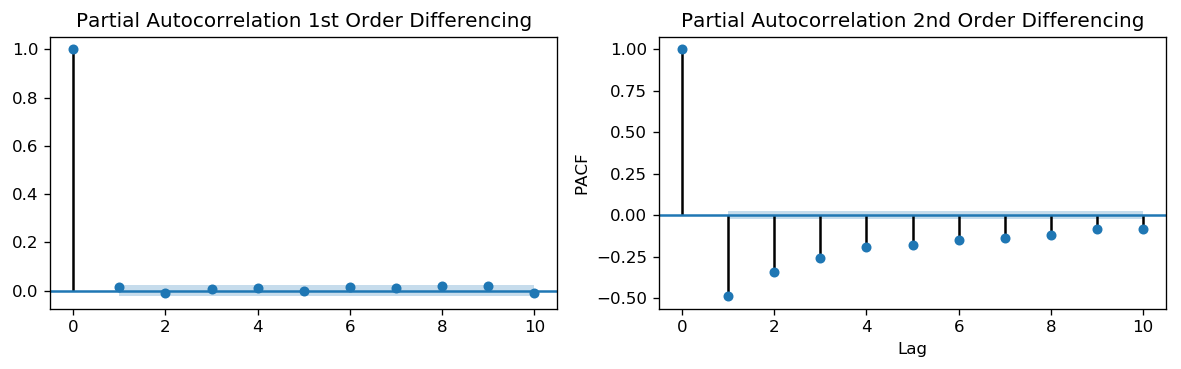

In [19]:
#Determine the number of the moving average by looking at the Partial Autocorrelation : p value should be one based on the Partial Autocorrelation 
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})
#Partial Auto-Correlation
from statsmodels.graphics.tsaplots import plot_pacf
fig, axes = plt.subplots(1, 2, sharex=True)
plot_pacf(daily_series_diff1, lags=10, ax=axes[0], title="Partial Autocorrelation 1st Order Differencing")
plot_pacf(daily_series_diff2, lags=10, ax=axes[1], title="Partial Autocorrelation 2nd Order Differencing")
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

In [38]:
from statsmodels.tsa.arima_model import ARIMA
# fit model
model = ARIMA(series, order=(1, 0, 1)).fit(transparams=False)
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 6939
Model:                     ARMA(1, 1)   Log Likelihood              -10505.876
Method:                       css-mle   S.D. of innovations                nan
Date:                Sat, 26 Oct 2019   AIC                          21019.752
Time:                        21:06:16   BIC                          21047.131
Sample:                    01-02-2000   HQIC                         21029.190
                         - 12-31-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.4283     17.947      3.868      0.000      34.252     104.604
ar.L1.y        0.9992      0.000   2089.596      0.000       0.998       1.000
ma.L1.y        0.0147      0.012      1.208      0.2

In [41]:
from fbprophet import Prophet
d={'ds':train['date'],'y':train['price']}
df_pred=pd.DataFrame(data=d)
# I took off Seasonality as Oil prices on weekends remain same as Friday until next opening on Monday
model = Prophet(daily_seasonality=False)
model.fit(df_pred)
future = model.make_future_dataframe(periods=273)
forecast = model.predict(future)
forecast2019 = forecast[(forecast['ds' ] >= '2019-01-01') & (forecast['ds' ] <= '2019-09-30')]

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


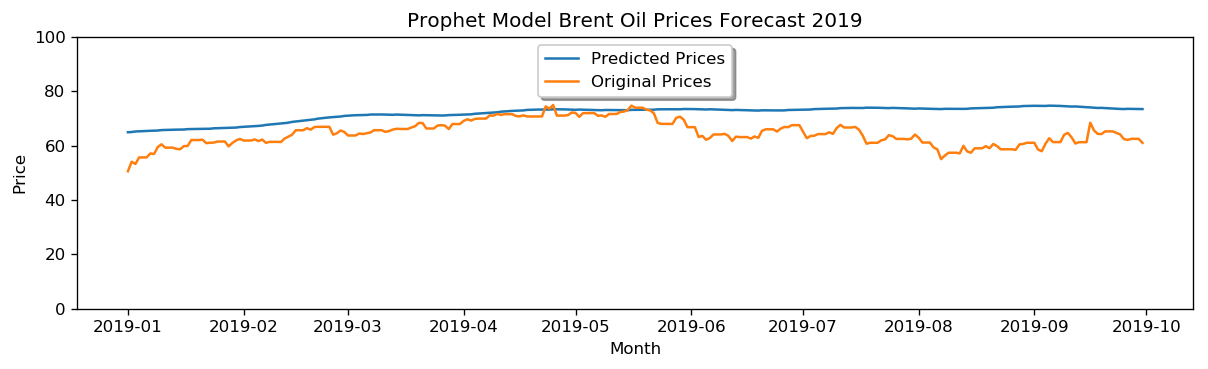

In [42]:
# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(forecast2019['ds'], forecast2019['yhat'], label='Predicted Prices')
ax.plot(test['date'], test['price'], label='Original Prices')
plt.ylim([0,100])
legend = ax.legend(loc='upper center', shadow=True)
plt.title('Prophet Model Brent Oil Prices Forecast 2019')
plt.xlabel('Month')
plt.ylabel('Price')
plt.show()

#### Forecast the oil prices for the period start='1/1/2019', end='9/30/2019'
#### typ='levels' if d is not set to zero (d = the number of nonseasonal differences)

In [23]:
ARIMA_Predict = model.predict(start='1/1/2019', end='9/30/2019')

In [45]:
#Standard deviation of residuals or Root-mean-square error (RMSD) https://www.youtube.com/watch?v=zMFdb__sUpw
mseProphet = mean_squared_error(test['price'],forecast2019['yhat'])
mseARIMA = mean_squared_error(test['price'],ARIMA_Predict)
rmseProphet = sqrt(mseProphet)
rmseARIMA = sqrt(mseARIMA)
print('The Mean Squared Error of ARIMA forecasts is {}'.format(round(mseARIMA, 2)))
print('The Root Mean Squared Error of ARIMA forecasts is {}'.format(round(rmseARIMA, 2)))
print('The Mean Squared Error of Prophet forecasts is {}'.format(round(mseProphet, 2)))
print('The Root Mean Squared Error of Prophet forecasts is {}'.format(round(rmseProphet, 2)))

The Mean Squared Error of ARIMA forecasts is 172.4
The Root Mean Squared Error of ARIMA forecasts is 13.13
The Mean Squared Error of Prophet forecasts is 72.6
The Root Mean Squared Error of Prophet forecasts is 8.52


In [46]:
#OR you may replace all the above with sklearn simple mae function:
from sklearn.metrics import mean_absolute_error
maeARIMA=mean_absolute_error(test['price'],ARIMA_Predict)
maeProphet=mean_absolute_error(test['price'],forecast2019['yhat'])
print('Mean Absolute Error ARIMA = {}'.format(round(maeARIMA, 2)))
print('Mean Absolute Error Prophet = {}'.format(round(maeProphet, 2)))

Mean Absolute Error ARIMA = 12.23
Mean Absolute Error Prophet = 7.27


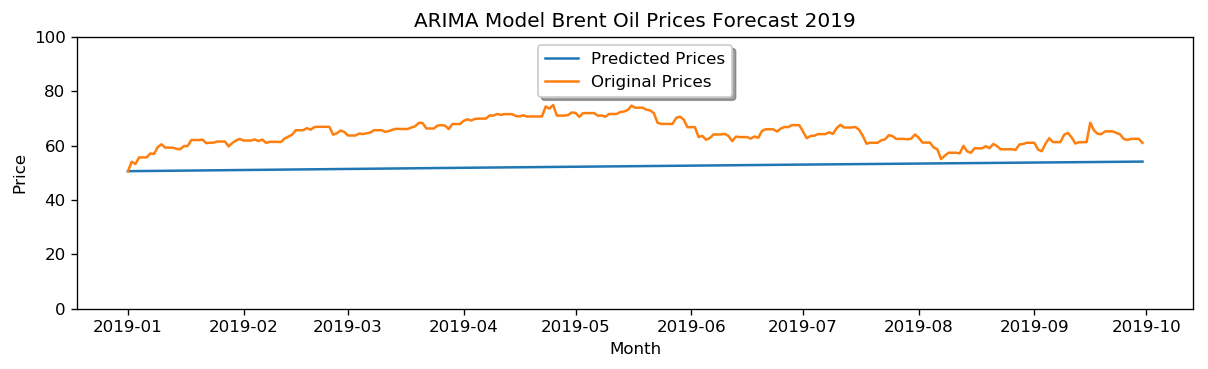

In [44]:
# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(forecast2019['ds'], ARIMA_Predict, label='Predicted Prices')
ax.plot(test['date'], test['price'], label='Original Prices')
plt.ylim([0,100])
legend = ax.legend(loc='upper center', shadow=True)
plt.title('ARIMA Model Brent Oil Prices Forecast 2019')
plt.xlabel('Month')
plt.ylabel('Price')
plt.show()

In [32]:
mae=mean_absolute_error(test['price'],ARIMA_Predict)
print('Mean Absolute Error = {}'.format(round(mae, 2)))

Mean Absolute Error = 12.23
